# Node Degree

## Load dependencies

In [102]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import dataframe_image as dfi
from statistics import mean
import networkx as nx

import config
from config import INTERACTOMES_PATH, DATA_REACTOME_PATH, PATHWAY_GRAPHS_PATH, genes, proteoforms, \
    COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL, no_sm, with_sm, with_unique_sm
from lib.dictionaries import read_dictionary_one_to_set
from lib.graph_database_access import get_query_result
from lib.networks import get_multiindex, get_json_filename, create_pathway_interaction_network, get_increase_percentage
from lib.networks import get_interactomes, get_combinations_with_pathways
from lib.networks import create_pathway_interaction_networks
from queries import QUERY_GET_PATHWAYS_BY_PROTEIN
from visualization.visualize_single_network import Coloring, plot_pathway_all_levels
import visualization.visualize_single_network as v

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial working directory: C:\git\ProteoformNetworks\src\Python
New working directory: c:\git\ProteoformNetworks


# Degree by Interactomes

## Load interactomes

In [103]:
index = get_multiindex()
interactomes_no_sm, interactomes_with_sm, interactomes_with_unique_sm = get_interactomes(DATA_REACTOME_PATH, INTERACTOMES_PATH)
interactomes = [interactomes_no_sm[genes], interactomes_no_sm[proteoforms], interactomes_with_sm[genes], interactomes_with_sm[proteoforms], interactomes_with_unique_sm[genes], interactomes_with_unique_sm[proteoforms]]

Reading participants of all reactions for level genes...
Reading participants of all reactions for level proteins...
Reading participants of all reactions for level proteoforms...
Reading participants of all reactions for level sm...
Reading components of all complexes for level genes...
Reading components of all complexes for level proteins...
Reading components of all complexes for level proteoforms...
Reading components of all complexes for level sm...
Reading interaction network for  at genes level, method no_sm...
Reading interaction network for  at proteins level, method no_sm...
Reading interaction network for  at proteoforms level, method no_sm...
Reading interaction network for  at genes level, method with_sm...
Reading interaction network for  at proteins level, method with_sm...
Reading interaction network for  at proteoforms level, method with_sm...
Reading interaction network for  at genes level, method with_unique_sm...
Reading interaction network for  at proteins level, 

## Degree of all proteoforms and its genes

In [104]:
map_proteins_to_genes = read_dictionary_one_to_set(INTERACTOMES_PATH, "mapping_proteins_to_genes.tsv", col_indices=(0, 1))
map_proteins_to_genes
proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm[proteoforms].degree()]
proteoform_degrees

df_degrees_genes_vs_all_proteoforms = pd.DataFrame(proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_all_proteoforms["Gene"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_all_proteoforms["Gene Degree"] = df_degrees_genes_vs_all_proteoforms["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_all_proteoforms["Annotations"] = df_degrees_genes_vs_all_proteoforms['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
df_degrees_genes_vs_all_proteoforms

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
0,P08887-2;,25,IL6R,15,True
1,P05231;,264,IL6,149,False
2,O60674;,166,JAK2,175,False
3,P23458;,143,JAK1,154,False
4,P29597;,86,TYK2,93,False
...,...,...,...,...,...
14241,Q9UN19;00048:139,2,DAPP1,1,True
14242,P40259;,68,CD79B,80,False
14243,P11912;,68,CD79A,80,False
14244,"P06241;00068:2,00115:3,00115:6",67,FYN,297,True


In [105]:
print(f"Average degree of all proteoforms: {mean(df_degrees_genes_vs_all_proteoforms['Proteoform Degree'])}")

Average degree of all proteoforms: 82.88853011371613


## Table with degree quartile values by Interactomes

In [106]:
columns = [
    "Q1 AE",
    "Q2 AE",
    "Q3 AE",
    "Q4 AE",
    "Avg AE",
    "Q1 SM",
    "Q2 SM",
    "Q3 SM",
    "Q4 SM",
    "Avg SM"
]

def get_tuples(G):
    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("S")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("S")]
    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    values_ae = np.quantile(deg_seq_acc_ents, [0,0.25,0.5,0.75,1])
    values_sm = [0] * 5
    avg_ae = mean(deg_seq_acc_ents)
    avg_sm = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        values_sm = np.quantile(deg_seq_sm_ents, [0,0.25,0.5,0.75,1])
        avg_sm = mean(deg_seq_sm_ents)
    return (*(values_ae)[1:], avg_ae, *(values_sm[1:]), avg_sm)

values = [get_tuples(I) for I in interactomes]
df_deg_interactomes = pd.DataFrame(values, columns=columns, index=index)
# df_deg_interactomes.drop(["Small Molecules","Entity Level"], axis=1)
dfi.export(df_deg_interactomes, "figures/table_interactomes_degree.png")
df_deg_interactomes

Q1 AE  Q2 AE  Q3 AE    Q4 AE  Avg AE  \
Small Molecules          Entity Level                                         
Not Included             genes          3.00  22.00  91.00 1,243.00   66.73   
                         proteoforms    4.00  23.00 109.00 1,474.00   82.89   
Included                 genes          5.00  25.00  98.00 1,290.00   72.88   
                         proteoforms    6.00  26.00 116.00 1,520.00   88.06   
Reaction-Unique Included genes          5.00  30.00 115.00 2,361.00   99.23   
                         proteoforms    6.00  30.00 128.00 2,376.00  108.99   

                                       Q1 SM  Q2 SM  Q3 SM    Q4 SM  Avg SM  
Small Molecules          Entity Level                                        
Not Included             genes          0.00   0.00   0.00     0.00    0.00  
                         proteoforms    0.00   0.00   0.00     0.00    0.00  
Included                 genes          4.00   7.00  20.00 3,473.00   50.09  
                         proteoforms    4.00   7.00  20.00 4,141.00   53.10  
Reaction-Unique Included genes          2.00   4.00  10.00   304.00   17.81  
                         proteoforms    2.00   4.00  10.00   304.00   18.32

## Plot degree distribution in the interactomes

In [107]:
degree_sequences = []
for interactome in interactomes:            
    accessioned_nodes = [node for node, data in interactome.nodes(data=True) if not data['type'].startswith("Simple")]
    sequence = sorted([d for n, d in interactome.degree(accessioned_nodes)], reverse=True)
    degree_sequences.append(sequence)

degree_sequences = pd.Series(degree_sequences, index=index)
degree_sequences

Small Molecules           Entity Level
Not Included              genes           [1243, 1220, 1059, 1059, 586, 579, 540, 530, 5...
                          proteoforms     [1474, 1449, 1284, 1284, 627, 619, 606, 604, 6...
Included                  genes           [1290, 1267, 1103, 1103, 765, 754, 645, 642, 6...
                          proteoforms     [1520, 1495, 1327, 1327, 780, 762, 747, 720, 7...
Reaction-Unique Included  genes           [2361, 2331, 1989, 1806, 1766, 1556, 1556, 153...
                          proteoforms     [2376, 2339, 2029, 1997, 1987, 1773, 1773, 153...
dtype: object

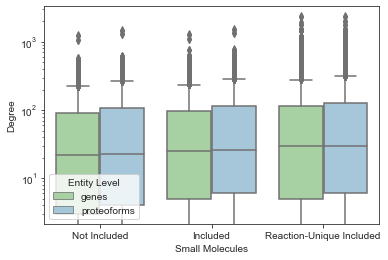

In [108]:
df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes.png')

In [109]:
degrees_genes = degree_sequences["Included", "genes"]
degrees_proteoforms = degree_sequences["Included", "proteoforms"]
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms))
print(f"the degree in the complete proteoform network is increased in average from {mean(degrees_genes)} to {mean(degrees_proteoforms)} connections ({change} %)")

the degree in the complete proteoform network is increased in average from 72.88073979591837 to 88.06310543310403 connections (29.79 %)


## Degree of proteoforms with annotations

In [110]:
proteoforms_no_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if not any((c in {':', '-'}) for c in str(node))]
proteoforms_with_annotations = [node for node in interactomes_no_sm['proteoforms'].nodes if any((c in {':', '-'}) for c in str(node))]

modified_proteoform_degrees = [(node, val) for (node, val) in interactomes_no_sm["proteoforms"].degree(proteoforms_with_annotations)]

df_degrees_genes_vs_proteoforms_with_annotations = pd.DataFrame(modified_proteoform_degrees, columns=["Proteoform", "Proteoform Degree"])
df_degrees_genes_vs_proteoforms_with_annotations["Gene"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: list(map_proteins_to_genes[proteoform[:re.search("[;-]", proteoform).start()]])[0])
df_degrees_genes_vs_proteoforms_with_annotations["Gene Degree"] = df_degrees_genes_vs_proteoforms_with_annotations["Gene"].apply(lambda gene: interactomes_no_sm[genes].degree[gene])
df_degrees_genes_vs_proteoforms_with_annotations["Annotations"] = df_degrees_genes_vs_proteoforms_with_annotations['Proteoform'].apply(lambda proteoform: any((c in {':', '-'}) for c in str(proteoform)))
dfi.export(df_degrees_genes_vs_proteoforms_with_annotations.set_index("Proteoform").sample(20), 'figures/table_interactomes_degree_genes_vs_modified_proteoforms.png')
df_degrees_genes_vs_proteoforms_with_annotations.sample(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations
1219,P0CG47;01148:200,16,UBB,1059,True
665,"Q96P44;00037:null,00039:null",536,COL21A1,58,True
1243,"Q12968;00046:168,00046:169,00046:171,00046:172...",9,NFATC3,8,True
1159,"Q9UM73;00048:1096,00048:1278,00048:1282,00048:...",36,ALK,34,True
1434,Q96GD3-2;,69,SCMH1,65,True
3342,"Q99062;00048:727,00048:752,00048:767,00048:787",35,CSF3R,32,True
878,P20908;00162:null,539,COL5A1,66,True
2021,Q96RI1-3;,85,NR1H4,57,True
2364,"Q8NB16;00046:358,00047:357",1,MLKL,2,True
53,O43236-6;,1,SEPTIN4,1,True


In [111]:
degrees_proteoforms_with_annotations = df_degrees_genes_vs_proteoforms_with_annotations["Proteoform Degree"]
print(f"Selected {len(degrees_proteoforms_with_annotations)} unique proteoforms.")
degrees_genes = df_degrees_genes_vs_proteoforms_with_annotations.drop_duplicates(subset= ["Gene"])["Gene Degree"]
print(f"Selected {len(degrees_genes)} unique genes.")
change = get_increase_percentage(len(degrees_genes), len(degrees_proteoforms_with_annotations))
print(f"the degree of annotated proteoform nodes in the complete proteoform network changes from {mean(degrees_genes)} to {mean(degrees_proteoforms_with_annotations)} connections ({change} %)")

Selected 3433 unique proteoforms.
Selected 1691 unique genes.
the degree of annotated proteoform nodes in the complete proteoform network changes from 83.89000591366056 to 113.1421497232741 connections (103.02 %)


## Plot degree of proteoforms with annotations

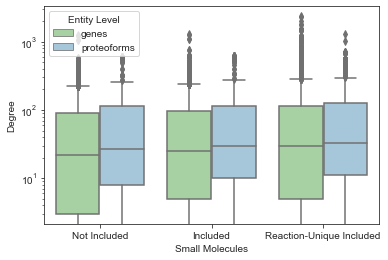

In [112]:
# The interactoms are 0: no_sm-genes, 1: no_sm-proteoforms, 2: with_sm-genes, 3: with_sm-proteoforms, 4: with_unique_sm-genes, 5: with_unique_sm-proteoforms
for i in [1, 3, 5]:
    degree_sequences[i] = [degree for proteoform_node, degree in interactomes[i].degree(proteoforms_with_annotations)]

degree_sequences = pd.Series(degree_sequences, index=index)

df_seq = pd.DataFrame({"Sequence": degree_sequences})
df_seq
df_seq.reset_index(inplace=True)

lst_col = 'Sequence'

df_seq = pd.DataFrame({
    col: np.repeat(df_seq[col].values, df_seq[lst_col].str.len())
    for col in df_seq.columns.drop(lst_col)}
).assign(**{lst_col: np.concatenate(df_seq[lst_col].values)})[df_seq.columns]

df_seq = df_seq.rename(columns={'Sequence': 'Degree'})
df_seq
ax = sns.boxplot(x="Small Molecules", y="Degree", hue="Entity Level",
                 data=df_seq, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
ax.set_yscale('log')
ax.figure.savefig('figures/degree_interactomes_proteoforms_with_annotations.png')

## Count proteoforms with higher or lower degree than genes

In [113]:
def getChange(value):
    if value > 0: return "+"
    elif value == 0: return "="
    else: return "-"

df_degrees_genes_vs_all_proteoforms["Degree Difference"] = df_degrees_genes_vs_all_proteoforms["Proteoform Degree"] - df_degrees_genes_vs_all_proteoforms["Gene Degree"]
df_degrees_genes_vs_all_proteoforms["Change"] = df_degrees_genes_vs_all_proteoforms["Degree Difference"].apply(lambda d: getChange(d))
df_degrees_genes_vs_all_proteoforms

print(f"For all proteoforms: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.groupby(['Change']).size(), columns=["Count"])

df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms) * 100
print(df_cases)

print(f"For proteoforms with annotations: ")
cases = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True].groupby(['Change']).size()
df_cases = pd.DataFrame(cases, columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]) * 100
print(df_cases)

print(f"For proteoforms no annotations: ")
df_cases = pd.DataFrame(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False].groupby(['Change']).size(), columns=["Count"])
df_cases["Percentage"] = df_cases["Count"] / len(df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]) * 100
print(df_cases)

For all proteoforms: 
        Count  Percentage
Change                   
+        4979       34.95
-        2688       18.87
=        6579       46.18
For proteoforms with annotations: 
        Count  Percentage
Change                   
+        1227       35.74
-        1960       57.09
=         246        7.17
For proteoforms no annotations: 
        Count  Percentage
Change                   
+        3752       34.70
-         728        6.73
=        6333       58.57


## Examples of proteoforms that have higher degree than gene nodes

In [114]:
df_degrees_genes_vs_all_proteoforms.sort_values(by = "Degree Difference").tail(20)

,Proteoform,Proteoform Degree,Gene,Gene Degree,Annotations,Degree Difference,Change
2857,Q9P218;00039:null,538,COL20A1,58,True,480,+
2832,Q02388;,601,COL7A1,121,False,480,+
2803,P12110;00039:null,546,COL6A2,66,True,480,+
2807,P12109;00039:null,546,COL6A1,66,True,480,+
2810,P12111;00039:null,546,COL6A3,66,True,480,+
2812,A8TX70;00039:null,546,COL6A5,66,True,480,+
2814,A6NMZ7;00039:null,546,COL6A6,66,True,480,+
1737,Q99715;00039:null,539,COL12A1,59,True,480,+
2846,P12107;00039:null,546,COL11A1,66,True,480,+
2848,P02458;00039:null,546,COL2A1,66,True,480,+


## Example of how the degree of some proteoforms increases

In [115]:
gene = "COL7A1"
protein = "Q02388"

# Get pathways in which gene X participates
pathways = get_query_result(QUERY_GET_PATHWAYS_BY_PROTEIN.replace("identifier:\"\"", f"identifier:\"{protein}\""))
pathway = "R-HSA-8934903"
# Check plots at gene and proteoform level

graphs = create_pathway_interaction_networks(pathway, config.PATHWAY_GRAPHS_PATH)
graphs
list(graphs[config.with_unique_sm][proteoforms].nodes())

m = nx.get_node_attributes(graphs[config.with_unique_sm][proteoforms], "gene")
# m['P67870;']
m

{'P67870;': 'CSNK2B',
 'P19784;': 'CSNK2A2',
 'P68400;': 'CSNK2A1',
 'Q8IVP5;': 'FUNDC1',
 'Q8IVP5;00046:13': 'FUNDC1',
 'O75385;': 'ULK1',
 'Q96HS1-2;': 'PGAM5',
 'P12931-1;': 'SRC',
 'Q8IVP5;00046:13,00048:18': 'FUNDC1',
 'Q8IVP5;00046:17': 'FUNDC1',
 'Q9H1Y0;': 'ATG5',
 'O94817;': 'ATG12',
 'Q9GZQ8;': 'MAP1LC3B',
 'Q9H492;': 'MAP1LC3A'}

In [116]:

nx.get_node_attributes(graphs[config.no_sm][config.proteoforms], "prevId")

p = v.plot_pathway_all_levels(pathway, out_path=PATHWAY_GRAPHS_PATH, graphs=graphs,
                                coloring=v.Coloring.ENTITY_TYPE, outline_line_width=1,
                                node_size=12,
                                inner_plot_size=350,
                                highlight_articulations=True,
                                highlight_bridges=True,
                                toolbar_location=None)

Plotting network for genes
with method: no_sm
Plotting network for proteoforms
with method: no_sm
Plotting network for genes
with method: with_sm
Plotting network for proteoforms
with method: with_sm
Plotting network for genes
with method: with_unique_sm
Plotting network for proteoforms
with method: with_unique_sm
Generated figure: networks/pathways/R-HSA-8934903_ENTITY_TYPE_network.html


## Plot degree of all proteoforms compared to gene degree

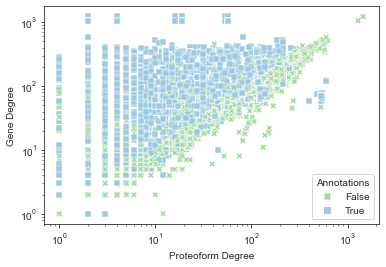

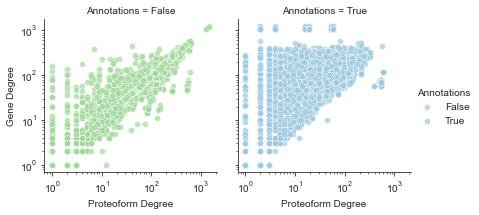

In [117]:
markers = {True: "s", False: "X"}
sns.set_style("ticks")
plot = sns.scatterplot(data=df_degrees_genes_vs_all_proteoforms, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

plot = sns.FacetGrid(df_degrees_genes_vs_all_proteoforms, col="Annotations", hue="Annotations", palette=[COLOR_GENES_FILL, COLOR_PROTEOFORMS_FILL])
plot.map(sns.scatterplot, "Proteoform Degree", "Gene Degree", alpha=.7, markers=markers)
plot.add_legend()
for ax in plot.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
plot.set(xscale="log", yscale="log")


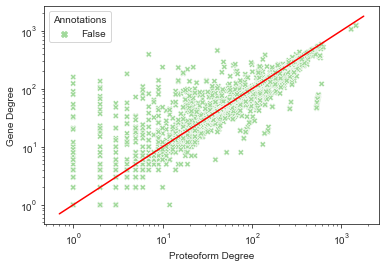

In [118]:
# Plot proteoform vs gene degree for non annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == False]

plot = sns.scatterplot(data=df, x="Proteoform Degree", y="Gene Degree", hue="Annotations", style="Annotations", markers=markers, palette=[COLOR_GENES_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

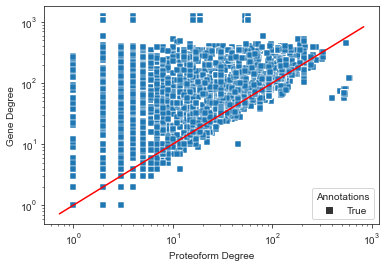

In [119]:
# Plot proteoform vs gene degree for annotated proteoforms

df = df_degrees_genes_vs_all_proteoforms.loc[df_degrees_genes_vs_all_proteoforms["Annotations"] == True]
plot = sns.scatterplot(data=df_degrees_genes_vs_proteoforms_with_annotations, x="Proteoform Degree", y="Gene Degree", style="Annotations", markers=markers, palette=[COLOR_PROTEOFORMS_FILL])
plot.set(xscale="log", yscale="log")

# Draw a line of x=y 
x0, x1 = plot.get_xlim()
y0, y1 = plot.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
plot.plot(lims, lims, '-r')

## Degree with small molecules

In [120]:
# The interactoms are 0: no_sm-genes, 1: no_sm-proteoforms, 2: with_sm-genes, 3: with_sm-proteoforms, 4: with_unique_sm-genes, 5: with_unique_sm-proteoforms

degree_gene_nodes_no_sm = list((d for n, d in interactomes_no_sm[genes].degree() if not n.startswith("sm")))
degree_gene_nodes_with_sm = list((d for n, d in interactomes_with_sm[genes].degree() if not n.startswith("sm")))
assert len(degree_gene_nodes_with_sm) == len(degree_gene_nodes_no_sm)

avg_degree_genes_no_sm = round(mean(degree_gene_nodes_no_sm),2)
avg_degree_genes_with_sm = round(mean(degree_gene_nodes_with_sm), 2)
change_gene_degree = round((avg_degree_genes_with_sm - avg_degree_genes_no_sm) * 100 / avg_degree_genes_no_sm, 2)

degree_proteoform_nodes_no_sm = list((d for n, d in interactomes_no_sm[proteoforms].degree() if not n.startswith("sm")))
degree_proteoform_nodes_with_sm = list((d for n, d in interactomes_with_sm[proteoforms].degree() if not n.startswith("sm")))

degree_proteoforms_no_sm = round(mean(degree_proteoform_nodes_no_sm), 2)
degree_proteoforms_with_sm = round(mean(degree_proteoform_nodes_with_sm), 2)
change_degree_proteoforms = round((degree_proteoforms_with_sm - degree_proteoforms_no_sm) / degree_proteoforms_no_sm * 100, 2)
print(f"With small molecules the average degree of the nodes increases by from {avg_degree_genes_no_sm} to {avg_degree_genes_with_sm} (+{change_gene_degree} %) and from {degree_proteoforms_no_sm} to {degree_proteoforms_with_sm} (+{change_degree_proteoforms} %), respectively")

With small molecules the average degree of the nodes increases by from 66.73 to 72.88 (+9.22 %) and from 82.89 to 88.06 (+6.24 %), respectively


## Extreme degree of nodes when adding small molecules

In [121]:
degree_all_nodes_gene_interactome_with_sm = list((d for n, d in interactomes_with_sm[genes].degree()))
degree_all_nodes_proteoform_interactome_with_sm = list((d for n, d in interactomes_with_sm[proteoforms].degree()))
print(f"There are hyperconnected nodes with up to {max(degree_all_nodes_gene_interactome_with_sm)} and {max(degree_all_nodes_proteoform_interactome_with_sm)} connections in the gene-centric and proteoform-centric networks.")

print(f"while the most connected genes and proteoforms present {max(degree_gene_nodes_with_sm)} and {max(degree_proteoform_nodes_with_sm)} connections.")

There are hyperconnected nodes with up to 3473 and 4141 connections in the gene-centric and proteoform-centric networks.
while the most connected genes and proteoforms present 1290 and 1520 connections.


## Degree with reaction-unique small molecules

In [122]:
degree_gene_nodes_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree() if not n.startswith("sm")))
degree_all_nodes_gene_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree()))
print(f"the average and maximal degree of nodes is increased to {round(mean(degree_gene_nodes_with_unique_sm), 2)} and {max(degree_gene_nodes_with_unique_sm)}, respectively, in the gene-centric network")

degree_proteoform_nodes_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree() if not n.startswith("sm")))
degree_all_nodes_proteoforms_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree()))
print(f"the average and maximal degree of nodes is increased to {round(mean(degree_proteoform_nodes_with_unique_sm), 2)} and {max(degree_proteoform_nodes_with_unique_sm)}, respectively, in the gene-centric network")

degree_sm_proteoform_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[proteoforms].degree() if n.startswith("sm")))
degree_sm_gene_interactome_with_unique_sm = list((d for n, d in interactomes_with_unique_sm[genes].degree() if n.startswith("sm")))
print(f"Max degree of small molecules is {max(degree_sm_gene_interactome_with_unique_sm)} and {max(degree_sm_proteoform_interactome_with_unique_sm)} for the gene-centric and proteoform-centric network.")

the average and maximal degree of nodes is increased to 99.23 and 2361, respectively, in the gene-centric network
the average and maximal degree of nodes is increased to 108.99 and 2376, respectively, in the gene-centric network
Max degree of small molecules is 304 and 304 for the gene-centric and proteoform-centric network.


# Degree by Pathways

## Select pathways with proteoforms with annotations

In [123]:
proteoforms_with_annotations
pathways_map = nx.get_node_attributes(interactomes_no_sm[proteoforms], "pathways")
selected_pathways = set()

for proteoform in proteoforms_with_annotations:
    for pathway in pathways_map[proteoform]:
        selected_pathways.add(pathway)
print(f"There are {len(selected_pathways)} pathways with proteoforms with annotations.")
df_selected_pathways = pd.DataFrame(selected_pathways, columns=["Pathway"])
df_selected_pathways.sort_values(by=["Pathway"], inplace=True)
df_selected_pathways

There are 1119 pathways with proteoforms with annotations.


,Pathway
855,R-HSA-1059683
11,R-HSA-109704
1026,R-HSA-110056
653,R-HSA-110312
263,R-HSA-110314
...,...
200,R-HSA-977347
68,R-HSA-977606
940,R-HSA-982772
897,R-HSA-983231


## Calculate metrics for each pathway

In [124]:
columns = [
    'Pathway',
    'Genes',
    'Proteoforms',
    'Small Molecules',
    'Diff Nodes Genes to Proteoforms',
    '% Change Nodes',
    'Gene links',
    'Proteoform links',
    'Diff Links Genes to Proteoforms',
    '% Change Links'
]


def get_pathway_tuples(pathway, graphs):
    
    gene_nodes = [node for node in graphs[no_sm][genes].nodes]
    proteoform_nodes = [node for node in graphs[no_sm][proteoforms].nodes]
    small_molecule_nodes = [node for node in graphs[with_sm][genes].nodes if str(node).startswith("sm")]
    assert len(gene_nodes) + len(small_molecule_nodes) == graphs[with_sm][genes].number_of_nodes()
    assert len(proteoform_nodes) + len(small_molecule_nodes) == graphs[with_sm][proteoforms].number_of_nodes()

    gene_links = graphs[no_sm][genes].number_of_edges()
    proteoform_links = graphs[no_sm][proteoforms].number_of_edges()

    diff_nodes = graphs[no_sm][proteoforms].number_of_nodes() - graphs[no_sm][genes].number_of_nodes()
    increase_nodes = diff_nodes / graphs[no_sm][genes].number_of_nodes() * 100
    diff_links = 0
    increase_links = 0;
    if graphs[no_sm][genes].number_of_edges() > 0:    
        diff_links = graphs[no_sm][proteoforms].number_of_edges() - graphs[no_sm][genes].number_of_edges()
        increase_links = diff_links / graphs[no_sm][genes].number_of_edges() * 100

    return (
        pathway,
        len(gene_nodes),
        len(proteoform_nodes),
        len(small_molecule_nodes),
        diff_nodes,
        f"{round(increase_nodes, 2):+}",
        gene_links,
        proteoform_links,
        diff_links,
        f"{round(increase_links, 2):+}",
    )

selected_pathways = list(df_selected_pathways["Pathway"])
data_pathways = []
for pathway in selected_pathways:
    pathway_graphs = {}
    for method in [no_sm, with_sm]:
        by_level = {}
        for level in [genes, proteoforms]:    
            filename = get_json_filename(level, method, PATHWAY_GRAPHS_PATH, pathway)
            by_level[level] = create_pathway_interaction_network(pathway, level, method, PATHWAY_GRAPHS_PATH)
        pathway_graphs[method] = by_level
    data_pathways.append(get_pathway_tuples(pathway, pathway_graphs))

df_pathways = pd.DataFrame.from_records(data_pathways, columns=columns)
df_pathways

,Pathway,Genes,Proteoforms,Small Molecules,Diff Nodes Genes to Proteoforms,% Change Nodes,Gene links,Proteoform links,Diff Links Genes to Proteoforms,% Change Links
0,R-HSA-1059683,11,22,2,11,+100.0,49,143,94,+191.84
1,R-HSA-109704,43,51,5,8,+18.6,3,3,0,+0.0
2,R-HSA-110056,10,15,2,5,+50.0,37,55,18,+48.65
3,R-HSA-110312,16,17,3,1,+6.25,120,136,16,+13.33
4,R-HSA-110314,30,31,0,1,+3.33,405,435,30,+7.41
...,...,...,...,...,...,...,...,...,...,...
1114,R-HSA-977347,9,9,16,0,+0.0,0,0,0,+0
1115,R-HSA-977606,127,140,4,13,+10.24,3950,4638,688,+17.42
1116,R-HSA-982772,24,35,5,11,+45.83,101,153,52,+51.49
1117,R-HSA-983231,139,146,16,7,+5.04,1199,1273,74,+6.17


## Show some example pathways

In [125]:
df_pathways.sample(10)

,Pathway,Genes,Proteoforms,Small Molecules,Diff Nodes Genes to Proteoforms,% Change Nodes,Gene links,Proteoform links,Diff Links Genes to Proteoforms,% Change Links
70,R-HSA-139910,3,4,2,1,+33.33,3,5,2,+66.67
850,R-HSA-8875360,15,18,2,3,+20.0,105,116,11,+10.48
897,R-HSA-8980692,149,150,4,1,+0.67,1335,1383,48,+3.6
893,R-HSA-8964058,10,11,12,1,+10.0,9,10,1,+11.11
40,R-HSA-1222556,36,36,40,0,+0.0,268,268,0,+0.0
1005,R-HSA-9615017,30,31,4,1,+3.33,75,81,6,+8.0
99,R-HSA-159230,36,40,0,4,+11.11,628,778,150,+23.89
701,R-HSA-5696397,25,26,2,1,+4.0,297,322,25,+8.42
929,R-HSA-9018677,8,9,13,1,+12.5,0,1,0,+0
753,R-HSA-68884,13,15,2,2,+15.38,31,33,2,+6.45


## Select pathways with most node change from genes to proteoforms

In [126]:
df_pathways.sort_values(by=['Diff Nodes Genes to Proteoforms'], ascending=False, inplace=True)
df_pathways.head(10)

# for example in examples:
#     graphs = create_pathway_interaction_networks(example, "resources/pathway_networks/")
#     p = plot_pathway_all_levels(example, out_path="resources/pathway_networks/", graphs=graphs,
#                                 coloring=Coloring.ENTITY_TYPE, outline_line_width=1,
#                                 node_size = 12,
#                                 inner_plot_size=350,
#                                 highlight_articulations=True,
#                                 highlight_bridges=True,
#                                 toolbar_location='below')

,Pathway,Genes,Proteoforms,Small Molecules,Diff Nodes Genes to Proteoforms,% Change Nodes,Gene links,Proteoform links,Diff Links Genes to Proteoforms,% Change Links
122,R-HSA-1650814,67,551,9,484,+722.39,1717,143683,141966,+8268.26
877,R-HSA-8948216,44,523,0,479,+1088.64,40,8053,8013,+20032.5
253,R-HSA-2022090,53,382,2,329,+620.75,60,907,847,+1411.67
81,R-HSA-1442490,40,183,5,143,+357.5,28,1456,1428,+5100.0
85,R-HSA-1474228,91,212,2,121,+132.97,325,1490,1165,+358.46
314,R-HSA-216083,66,186,1,120,+181.82,240,2251,2011,+837.92
395,R-HSA-3247509,145,261,4,116,+80.0,1098,4370,3272,+298.0
390,R-HSA-3214847,108,222,2,114,+105.56,987,3294,2307,+233.74
451,R-HSA-381426,124,229,3,105,+84.68,5738,22328,16590,+289.13
886,R-HSA-8957275,107,212,2,105,+98.13,5671,22261,16590,+292.54


## Select pathways with most connections change from genes to proteoforms

In [127]:
df_pathways.sort_values(by=['Diff Links Genes to Proteoforms'], ascending=False, inplace=True)
df_pathways.head(12)

,Pathway,Genes,Proteoforms,Small Molecules,Diff Nodes Genes to Proteoforms,% Change Nodes,Gene links,Proteoform links,Diff Links Genes to Proteoforms,% Change Links
122,R-HSA-1650814,67,551,9,484,+722.39,1717,143683,141966,+8268.26
451,R-HSA-381426,124,229,3,105,+84.68,5738,22328,16590,+289.13
886,R-HSA-8957275,107,212,2,105,+98.13,5671,22261,16590,+292.54
877,R-HSA-8948216,44,523,0,479,+1088.64,40,8053,8013,+20032.5
1000,R-HSA-9609690,85,167,4,82,+96.47,1564,7529,5965,+381.39
848,R-HSA-8873719,65,125,3,60,+92.31,2018,7628,5610,+278.0
387,R-HSA-3214815,60,138,3,78,+130.0,1565,6752,5187,+331.44
242,R-HSA-198933,214,288,19,74,+34.58,3832,8836,5004,+130.58
1078,R-HSA-9705671,122,206,14,84,+68.85,979,4670,3691,+377.02
395,R-HSA-3247509,145,261,4,116,+80.0,1098,4370,3272,+298.0


## Get change for adding small molecules

In [128]:
for method in config.SMALL_MOLECULES:
    print(f"Small Molecules: {method}")
    avg_genes = df_deg_interactomes.loc[method,'genes']["Avg AE"]
    avg_proteoforms = df_deg_interactomes.loc[method,'proteoforms']["Avg AE"]
    inc_genes_proteoforms = get_increase_percentage(avg_genes, avg_proteoforms)
    print(f"There is an increase of degree: {inc_genes_proteoforms}% from genes to proteoforms")


Small Molecules: Not Included
There is an increase of degree: 24.22% from genes to proteoforms
Small Molecules: Included
There is an increase of degree: 20.83% from genes to proteoforms
Small Molecules: Reaction-Unique Included
There is an increase of degree: 9.84% from genes to proteoforms


## Table for degree by pathways

In [129]:
combinations = get_combinations_with_pathways(selected_pathways)

columns = [
    "Small Molecules",
    "Entity Level",
    "Pathway",
    "Min. AE",
    "Avg. AE",
    "Max. AE",
    "Min. SM",
    "Avg. SM",
    "Max. SM"
]

def get_tuples(combination):
    G = create_pathway_interaction_network(
        method=combination[0], level=combination[1], pathway=combination[2], out_path=PATHWAY_GRAPHS_PATH
    )

    acc_ents = list(G.nodes)
    sm_ents = []
    if G.graph['num_small_molecules'] > 0:
        acc_ents = [n for n in G.nodes if not G.nodes[n]['type'].startswith("Simple")]
        sm_ents = [n for n in G.nodes if G.nodes[n]['type'].startswith("Simple")]

    deg_seq_acc_ents = [d for n, d in list(G.degree(acc_ents))]
    min_deg_sm_ents = 0
    avg_deg_sm_ents = 0
    max_deg_sm_ents = 0
    if len(sm_ents) > 0:
        deg_seq_sm_ents = [d for n, d in list(G.degree(sm_ents))]
        min_deg_sm_ents = min(deg_seq_sm_ents)
        avg_deg_sm_ents = mean(deg_seq_sm_ents)
        max_deg_sm_ents = max(deg_seq_sm_ents)

    return (
        combination[0], combination[1], combination[2],
        min(deg_seq_acc_ents), mean(deg_seq_acc_ents), max(deg_seq_acc_ents),
        min_deg_sm_ents, avg_deg_sm_ents, max_deg_sm_ents
    )

In [130]:
df_deg_pathways = pd.DataFrame([get_tuples(combination) for combination in combinations], columns=columns)
df_deg_pathways.sort_values(by=["Pathway", "Entity Level", "Small Molecules"], inplace=True)
df_deg_pathways

,Small Molecules,Entity Level,Pathway,Min. AE,Avg. AE,Max. AE,Min. SM,Avg. SM,Max. SM
0,no_sm,genes,R-HSA-1059683,7,8.91,10,0,0.00,0
2238,with_sm,genes,R-HSA-1059683,7,10.64,12,10,10.50,11
4476,with_unique_sm,genes,R-HSA-1059683,7,15.36,20,7,8.10,10
1119,no_sm,proteoforms,R-HSA-1059683,6,13.00,21,0,0.00,0
3357,with_sm,proteoforms,R-HSA-1059683,6,14.36,23,14,16.00,18
...,...,...,...,...,...,...,...,...,...
3356,with_sm,genes,R-HSA-983695,1,72.18,85,3,54.38,87
5594,with_unique_sm,genes,R-HSA-983695,2,85.62,102,1,34.84,79
2237,no_sm,proteoforms,R-HSA-983695,0,71.69,87,0,0.00,0
4475,with_sm,proteoforms,R-HSA-983695,1,75.78,92,3,55.88,91


In [131]:
df_deg_pathways_agg = df_deg_pathways.groupby(['Small Molecules', 'Entity Level']).agg(
    {
        "Min. AE": ['mean'],
        "Avg. AE": ['mean'],
        "Max. AE": ['mean'],
        "Min. SM": ['mean'],
        "Avg. SM": ['mean'],
        "Max. SM": ['mean']
    })
df_deg_pathways_agg.columns = [
    "Min. AE",
    "Avg. AE",
    "Max. AE",
    "Min. SM",
    "Avg. SM",
    "Max. SM"
]
df_pathways_grouped = df_deg_pathways_agg.set_index(get_multiindex())
dfi.export(df_pathways_grouped, 'figures/table_pathways_degree.png')
df_pathways_grouped



Min. AE  Avg. AE  Max. AE  Min. SM  \
Small Molecules          Entity Level                                       
Not Included             genes            5.12    15.72    24.33     0.00   
                         proteoforms      5.07    17.72    28.16     0.00   
Included                 genes            6.01    17.55    27.31     7.23   
                         proteoforms      5.83    19.40    30.96     7.80   
Reaction-Unique Included genes            6.30    20.44    34.27     3.74   
                         proteoforms      6.06    21.91    37.47     3.86   

                                       Avg. SM  Max. SM  
Small Molecules          Entity Level                    
Not Included             genes            0.00     0.00  
                         proteoforms      0.00     0.00  
Included                 genes           12.34    18.58  
                         proteoforms     13.56    20.96  
Reaction-Unique Included genes            8.66    14.63  
                         proteoforms      9.12    15.93

Text(0.5, 1.0, 'Distribution of Avg. Degree of Accessioned Entities in all Pathways')

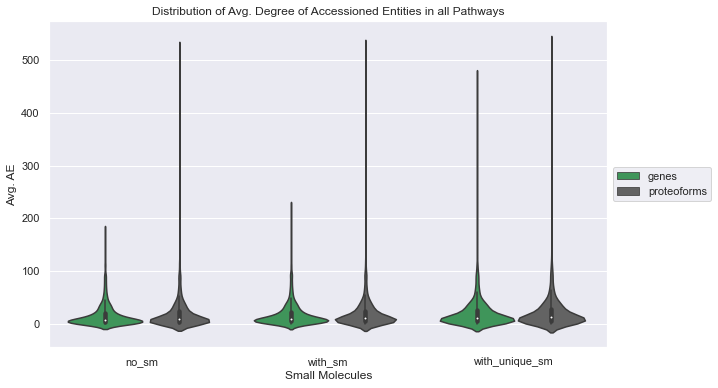

In [132]:
import matplotlib.pyplot as plt

sns.set(rc = {"figure.facecolor": "white"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. AE", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Accessioned Entities in all Pathways")

Text(0.5, 1.0, 'Distribution of Avg. Degree of Small Molecules in all Pathways')

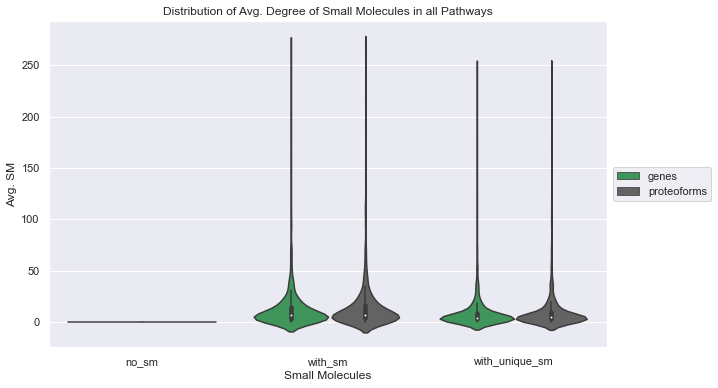

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
fig.set_size_inches(10, 6)
f = sns.violinplot(x="Small Molecules", y="Avg. SM", hue="Entity Level",
                   data=df_deg_pathways, palette=config.COLORS_BORDER)
#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$")) # Convert ticks to powers of 10
f.legend(loc='center left', bbox_to_anchor=(1, 0.5))
f.set_title("Distribution of Avg. Degree of Small Molecules in all Pathways")

In [134]:
df_deg_pathways[
    (df_deg_pathways["Small Molecules"] == 'with_unique_sm') & (df_deg_pathways["Entity Level"] == 'proteoforms')]

,Small Molecules,Entity Level,Pathway,Min. AE,Avg. AE,Max. AE,Min. SM,Avg. SM,Max. SM
5595,with_unique_sm,proteoforms,R-HSA-1059683,6,16.68,31,8,9.10,11
5596,with_unique_sm,proteoforms,R-HSA-109704,1,1.98,3,1,13.38,49
5597,with_unique_sm,proteoforms,R-HSA-110056,3,8.07,15,3,3.75,5
5598,with_unique_sm,proteoforms,R-HSA-110312,18,18.88,19,15,17.00,18
5599,with_unique_sm,proteoforms,R-HSA-110314,15,28.06,30,0,0.00,0
...,...,...,...,...,...,...,...,...,...
6709,with_unique_sm,proteoforms,R-HSA-977347,1,2.22,7,1,2.73,5
6710,with_unique_sm,proteoforms,R-HSA-977606,1,66.42,94,1,2.70,4
6711,with_unique_sm,proteoforms,R-HSA-982772,1,11.74,46,3,6.58,11
6712,with_unique_sm,proteoforms,R-HSA-983231,1,17.54,44,1,2.46,4


In [135]:
df_pathways_grouped.reset_index(inplace=True)
df_pathways_grouped

,Small Molecules,Entity Level,Min. AE,Avg. AE,Max. AE,Min. SM,Avg. SM,Max. SM
0,Not Included,genes,5.12,15.72,24.33,0.00,0.00,0.00
1,Not Included,proteoforms,5.07,17.72,28.16,0.00,0.00,0.00
2,Included,genes,6.01,17.55,27.31,7.23,12.34,18.58
3,Included,proteoforms,5.83,19.40,30.96,7.80,13.56,20.96
4,Reaction-Unique Included,genes,6.30,20.44,34.27,3.74,8.66,14.63
5,Reaction-Unique Included,proteoforms,6.06,21.91,37.47,3.86,9.12,15.93


In [137]:
df_interactomes_temp = df_deg_interactomes[["Avg AE",
    "Avg AE"]]
df_interactomes_temp.reset_index(inplace=True)
df_interactomes_temp

,Small Molecules,Entity Level,Avg AE,Avg AE
0,Not Included,genes,66.73,66.73
1,Not Included,proteoforms,82.89,82.89
2,Included,genes,72.88,72.88
3,Included,proteoforms,88.06,88.06
4,Reaction-Unique Included,genes,99.23,99.23
5,Reaction-Unique Included,proteoforms,108.99,108.99


In [139]:
df_degrees = pd.concat([df_interactomes_temp, df_pathways_grouped[["Avg. AE",
    "Avg. SM"]]], axis=1)
df_degrees.set_index(index, inplace=True)
df_degrees.drop(df_degrees.columns[[0,1]],axis=1,inplace=True)
df_degrees

Avg AE  Avg AE  Avg. AE  Avg. SM
Small Molecules          Entity Level                                  
Not Included             genes          66.73   66.73    15.72     0.00
                         proteoforms    82.89   82.89    17.72     0.00
Included                 genes          72.88   72.88    17.55    12.34
                         proteoforms    88.06   88.06    19.40    13.56
Reaction-Unique Included genes          99.23   99.23    20.44     8.66
                         proteoforms   108.99  108.99    21.91     9.12